In [17]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [18]:
train_dataset = datasets.MNIST(
    root="data",
    train = True,
    download = True,
    transform = ToTensor()
)
test_dataset = datasets.MNIST(
    root="data",
    train = False,
    download = True,
    transform = ToTensor()
)

In [19]:
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=64,
    shuffle=True
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=64,
    shuffle=False
)

In [6]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 10, 3
img, label = train_dataset[0]
d1, d2, d3 = img.shape
img_map = torch.zeros(cols, rows, d1, d2, d3)
cnt = np.zeros(cols, dtype=int)
print(cnt.dtype)

while np.sum(cnt) < cols *rows:
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    if cnt[label] >= rows:
        continue
    img_map[label][cnt[label]] = img
    cnt[label] += 1
    print(np.sum(cnt))

int64
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


<Figure size 800x800 with 0 Axes>

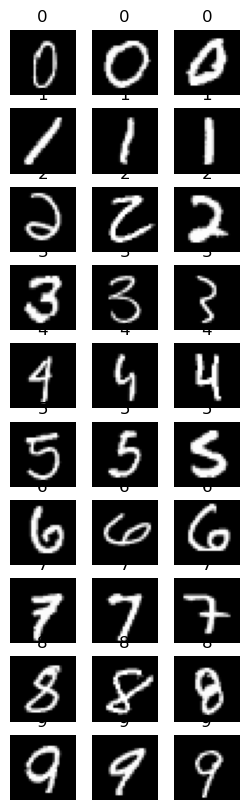

In [7]:
figure = plt.figure(figsize=(rows, cols))
for i in range(cols):
    for j in range(rows):
        figure.add_subplot(cols, rows, i * rows + j + 1)
        plt.title(i)
        plt.axis("off")
        plt.imshow(img_map[i][j].squeeze(), cmap=plt.cm.gray)
plt.show()

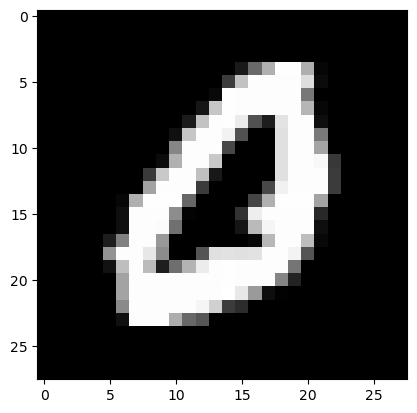

In [8]:
plt.imshow(img_map[0][2].squeeze(), cmap=plt.cm.gray)

In [20]:
import os
from torch import nn
from torchvision import transforms

In [21]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [22]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1*28*28, 10),
            nn.ReLU(),
            nn.Linear(10, 10),
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [12]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)


In [23]:
lr = 1e-3
batch_size = 64
epochs = 5

In [26]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [25]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    ls = 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        ls = loss.item()
        if batch % 100 == 0:
            loss, current = loss.item(), batch *batch_size+len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return ls

def test_loop(dataloader, model, loss_fn):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return correct

In [16]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    test_loop(test_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.347504  [   64/60000]
loss: 2.329800  [ 6464/60000]
loss: 2.307796  [12864/60000]
loss: 2.270128  [19264/60000]
loss: 2.295522  [25664/60000]
loss: 2.267785  [32064/60000]
loss: 2.300437  [38464/60000]
loss: 2.256224  [44864/60000]
loss: 2.277967  [51264/60000]
loss: 2.217992  [57664/60000]
Test Error: 
 Accuracy: 16.3%, Avg loss: 2.231842 

Epoch 2
-------------------------------
loss: 2.240196  [   64/60000]
loss: 2.232144  [ 6464/60000]
loss: 2.242815  [12864/60000]
loss: 2.228921  [19264/60000]
loss: 2.199683  [25664/60000]
loss: 2.163222  [32064/60000]
loss: 2.174788  [38464/60000]
loss: 2.129900  [44864/60000]
loss: 2.109182  [51264/60000]
loss: 2.087689  [57664/60000]
Test Error: 
 Accuracy: 36.2%, Avg loss: 2.099398 

Epoch 3
-------------------------------
loss: 2.087925  [   64/60000]
loss: 2.073469  [ 6464/60000]
loss: 2.062246  [12864/60000]
loss: 2.055879  [19264/60000]
loss: 2.019403  [25664/60000]
loss: 2.003317  [32064/600

KeyboardInterrupt: 

In [27]:
class ConvolutionalNeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, stride = 1, padding=1) #28->28
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding=1) #14->14
        self.pool = nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0)
        self.flatten = nn.Flatten()

        self.conv_pool_stack = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, stride = 1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0),
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2, padding = 0),
        )

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(64*7*7, 128),
            nn.Dropout(0.1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        x = self.conv_pool_stack(x)
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


In [28]:
model = ConvolutionalNeuralNetwork().to(device)
print(model)
lr = 1e-3
batch_size = 64
epochs = 5
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

ConvolutionalNeuralNetwork(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv_pool_stack): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3136, out_features=128, bias=True)
    (1): Dropout(p=0.1, inplace=False)
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True

In [29]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [30]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    test_loop(test_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.467604  [   64/60000]
loss: 0.111603  [ 6464/60000]
loss: 0.142223  [12864/60000]
loss: 0.111777  [19264/60000]
loss: 0.120618  [25664/60000]
loss: 0.026211  [32064/60000]
loss: 0.226209  [38464/60000]
loss: 0.022835  [44864/60000]
loss: 0.042854  [51264/60000]
loss: 0.012631  [57664/60000]
Test Error: 
 Accuracy: 98.8%, Avg loss: 0.038088 

Epoch 2
-------------------------------
loss: 0.060569  [   64/60000]
loss: 0.028592  [ 6464/60000]
loss: 0.072845  [12864/60000]
loss: 0.033548  [19264/60000]
loss: 0.007375  [25664/60000]
loss: 0.040570  [32064/60000]
loss: 0.027447  [38464/60000]
loss: 0.016187  [44864/60000]
loss: 0.012367  [51264/60000]
loss: 0.034438  [57664/60000]
Test Error: 
 Accuracy: 99.0%, Avg loss: 0.032178 

Epoch 3
-------------------------------
loss: 0.019065  [   64/60000]
loss: 0.012035  [ 6464/60000]
loss: 0.048371  [12864/60000]
loss: 0.011623  [19264/60000]
loss: 0.012184  [25664/60000]
loss: 0.018124  [32064/600

KeyboardInterrupt: 

In [38]:
lr_arr = [1e-6, 1e-5, 1e-4, 1e-3]
weight_decays = [1e-6, 1e-5, 1e-4, 1e-3]

test_map = {}

# 학습률이 높은 것부터 낮은 것 순으로 역순 순회
for lr in reversed(lr_arr):
    for weight_decay in reversed(weight_decays):
        model = ConvolutionalNeuralNetwork().to(device)
        loss_fn = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

        train_loop(train_loader, model, loss_fn, optimizer)
        acc = test_loop(test_loader, model, loss_fn)
        test_map[(lr, weight_decay)] = acc  # 결과 저장

# 결과 출력
for (lr_wd_pair, accuracy) in test_map.items():
    lr, wd = lr_wd_pair
    print(f"Learning Rate: {lr}, Weight Decay: {wd}, Accuracy: {accuracy:.2f}%")

loss: 2.419926  [   64/60000]
loss: 0.066423  [ 6464/60000]
loss: 0.082594  [12864/60000]
loss: 0.085157  [19264/60000]
loss: 0.081026  [25664/60000]
loss: 0.056585  [32064/60000]
loss: 0.028647  [38464/60000]
loss: 0.054725  [44864/60000]
loss: 0.026186  [51264/60000]
loss: 0.050598  [57664/60000]
Test Error: 
 Accuracy: 98.7%, Avg loss: 0.049646 

loss: 2.389387  [   64/60000]
loss: 0.106240  [ 6464/60000]
loss: 0.102662  [12864/60000]
loss: 0.058950  [19264/60000]
loss: 0.025543  [25664/60000]
loss: 0.009015  [32064/60000]
loss: 0.014249  [38464/60000]
loss: 0.030830  [44864/60000]
loss: 0.083367  [51264/60000]
loss: 0.049540  [57664/60000]
Test Error: 
 Accuracy: 99.0%, Avg loss: 0.036658 

loss: 2.481687  [   64/60000]
loss: 0.135959  [ 6464/60000]
loss: 0.132171  [12864/60000]
loss: 0.169484  [19264/60000]
loss: 0.019028  [25664/60000]
loss: 0.140224  [32064/60000]
loss: 0.038834  [38464/60000]
loss: 0.245075  [44864/60000]
loss: 0.013534  [51264/60000]
loss: 0.137484  [57664/600

KeyboardInterrupt: 

In [94]:
import matplotlib.pyplot as plt

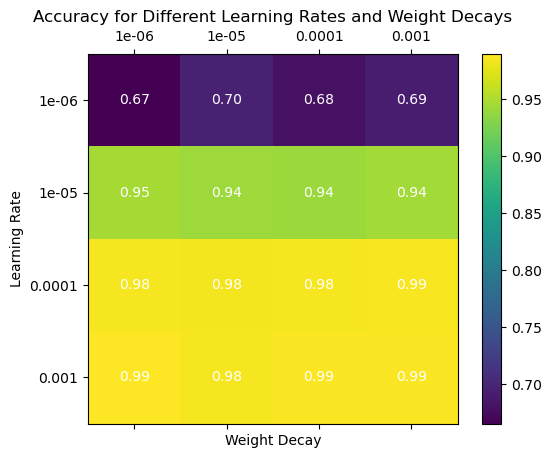

In [96]:
accuracy_matrix = np.zeros((len(lr_arr), len(weight_decays)))

for i, lr in enumerate(lr_arr):
    for j, weight_decay in enumerate(weight_decays):
        accuracy_matrix[i, j] = test_map.get((lr, weight_decay), 0)

# 시각화
fig, ax = plt.subplots()
cax = ax.matshow(accuracy_matrix, cmap='viridis')

# 학습률과 가중치 감쇠 레이블 설정
ax.set_xticks(np.arange(len(weight_decays)))
ax.set_yticks(np.arange(len(lr_arr)))
ax.set_xticklabels(weight_decays)
ax.set_yticklabels(lr_arr)

# 축 레이블 설정
plt.xlabel('Weight Decay')
plt.ylabel('Learning Rate')

# 컬러바 추가
plt.colorbar(cax)

# 그래프 제목 설정
plt.title('Accuracy for Different Learning Rates and Weight Decays')

# 값 표시
for i in range(len(lr_arr)):
    for j in range(len(weight_decays)):
        ax.text(j, i, f'{accuracy_matrix[i, j]:.2f}', ha='center', va='center', color='white')

plt.show()